### THIS NOTEBOOK CLASSIFIES THE DIFFERENT IMAGES OF DOGS AND CATS USING RESNET34 ARCHITECTURE.

In [1]:
import zipfile

with zipfile.ZipFile("../input/dogs-vs-cats/train.zip","r") as zip_ref:
    zip_ref.extractall("./")
with zipfile.ZipFile("../input/dogs-vs-cats/test1.zip","r") as zip_ref:
    zip_ref.extractall("./")

In [18]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torchvision import models

In [3]:
# CREATE DATAFRAME
categories = []
files = []
l = []
for image in os.listdir('./train'):
    ct = image.split('.')[0]
    categories.append(ct)
    files.append(image)
    if ct == 'dog':
        l.append(0)
    else:
        l.append(1)
    
dataframe = pd.DataFrame({'filename':files, 'category':categories, 'encoded_category':l})
dataframe

filename category  encoded_category
0       dog.913.jpg      dog                 0
1      cat.5196.jpg      cat                 1
2      dog.9806.jpg      dog                 0
3      dog.2195.jpg      dog                 0
4      dog.7320.jpg      dog                 0
...             ...      ...               ...
24995  dog.2925.jpg      dog                 0
24996  dog.1876.jpg      dog                 0
24997  dog.8442.jpg      dog                 0
24998  dog.2489.jpg      dog                 0
24999  cat.7834.jpg      cat                 1

[25000 rows x 3 columns]

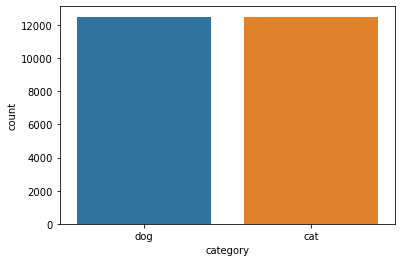

In [16]:
sns.countplot(dataframe.category)

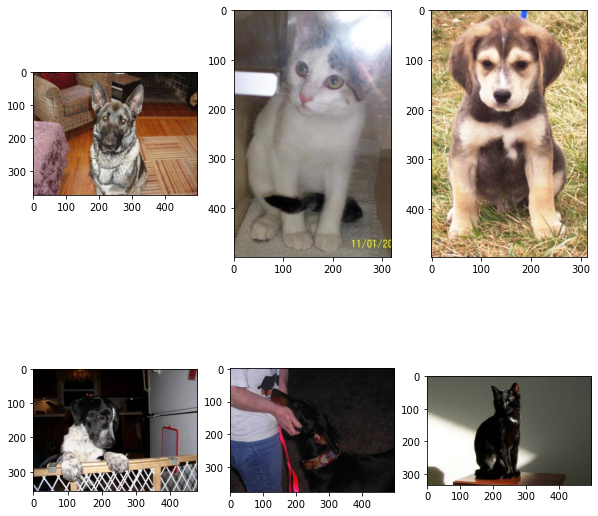

In [25]:
# VISUALIZE 
plt.figure(figsize=(10,10))
for i in range(6):
    plt.subplot(2,3, i+1)
    plt.imshow(read_image(dataframe.filename.values[i]))
plt.show()

In [57]:
# CREATE DATASETS AND DATALOADER

def read_image(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

def scale_image(image):
    return image/255.0

def resize_image(image):
    return cv2.resize(image, (300, 300))
    
def normalize_image(image):
    means = [0.485, 0.456, 0.406]
    stds = [0.229, 0.224, 0.225]
    image = (image - means)/stds
    return image

class dog_cat_dataset(torch.utils.data.Dataset):    
    def __init__(self, filename, category, train=False):
        if train == True:
            filename = './train/'+ filename
        else:
            filename = './test1/'+ filename
            
        self.filename = filename
        self.category = category
        
    def __len__(self):
        return len(self.category)
    
    def __getitem__(self, index):
        x = read_image(self.filename[index])
        x = resize_image(x)
        x = scale_image(x)
        x = normalize_image(x)
        x = np.rollaxis(x, 2)
        return x, self.category[index]
        

x_train, x_val, y_train, y_val = train_test_split(dataframe.filename, dataframe.encoded_category, test_size=0.2, random_state=42)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_ds = dog_cat_dataset(x_train.reset_index(drop=True), y_train.reset_index(drop=True), train=True)
valid_ds = dog_cat_dataset(x_val.reset_index(drop=True), y_val.reset_index(drop=True), train=True)

BATCH = 64
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH, shuffle=True)
valid_dl =  torch.utils.data.DataLoader(valid_ds, batch_size=BATCH)

In [33]:
class ResNetModel(torch.nn.Module):
    def __init__(self):
        super(ResNetModel, self).__init__()
        resnet = models.resnet34(pretrained=True)
        inputs = resnet.fc.in_features
        layers = list(resnet.children())[:8]
        self.feature1 = torch.nn.Sequential(*layers[:6])
        self.feature2 = torch.nn.Sequential(*layers[6:])
        self.classifier = torch.nn.Sequential(torch.nn.BatchNorm1d(inputs), torch.nn.Linear(inputs, 2))
    
    # RESNET > RELU > POOLING > FLATTEN > BATCHNORM > LINEAR > SOFTMAX
    def forward(self, x):
        x = self.feature1(x)
        x = self.feature2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        out_class = self.classifier(x)
        return torch.nn.functional.softmax(out_class, dim=1)

def train_model(model, optimizer, train_dl, valid_dl, epochs):
    model.train()
    for i in range(epochs):
        total = 0
        sum_loss = 0
        
        for x, y in train_dl:
            x = x.to(device).float()
            y = y.to(device)
            
            # FORWARD PASS
            out_class = model(x)
            # CALCULATE LOSS
            loss = torch.nn.functional.cross_entropy(out_class, y, reduction='sum')
            # INITIALIZE THE GRADIENTS
            optimizer.zero_grad()
            # BACKPROPAGATE THE LOSS
            loss.backward()
            # UPDATE THE WEIGHTS
            optimizer.step()
            
            total += y.shape[0]
            sum_loss += loss.item()
            
        train_loss = sum_loss / total
        val_loss, val_acc = validation_model(model, valid_dl)
        print(' EPOCH {} train_loss {:.3f} val_loss {:.3f} val_acc {:.3f}'.format(i, train_loss, val_loss, val_acc))
    return sum_loss/total
        
def validation_model(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        x = x.to(device).float()
        y = y.to(device)
        batch = y.shape[0]
        out_class = model(x)
        loss = torch.nn.functional.cross_entropy(out_class, y)
        
        _, index = torch.max(out_class, 1)
        correct += index.eq(y).sum().item()
        sum_loss += loss.item()
        total += batch
        
    return sum_loss/total, correct/total

In [36]:
model = ResNetModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, optimizer, train_dl, valid_dl, 1)

 EPOCH 0 train_loss 0.417 val_loss 0.006 val_acc 0.921


0.4169363065242767

In [65]:
t = []
for i in os.listdir('./test1'):
    t.append(i)
    
test_ds = pd.DataFrame({'filename':t, 'label':pd.Series(np.zeros(len(t)))})
test_ds.head()

filename  label
0  10168.jpg    0.0
1   8290.jpg    0.0
2   6808.jpg    0.0
3   7477.jpg    0.0
4  11837.jpg    0.0

In [81]:
test_data = dog_cat_dataset(test_ds.filename, test_ds.label)
animal = {0:'dog', 1:'cat'}

def inference_code(index):
    image, *_ = test_data[index]
    image = torch.FloatTensor(image[None, ])
    out_class = model(image.to(device))
    y_class = out_class.cpu().data.numpy().argmax()
    confidence = out_class.cpu().data.numpy()[0][y_class]
    return animal[y_class], confidence

In [92]:
len(test_data)

12500

### FIRST 30 IMAGES

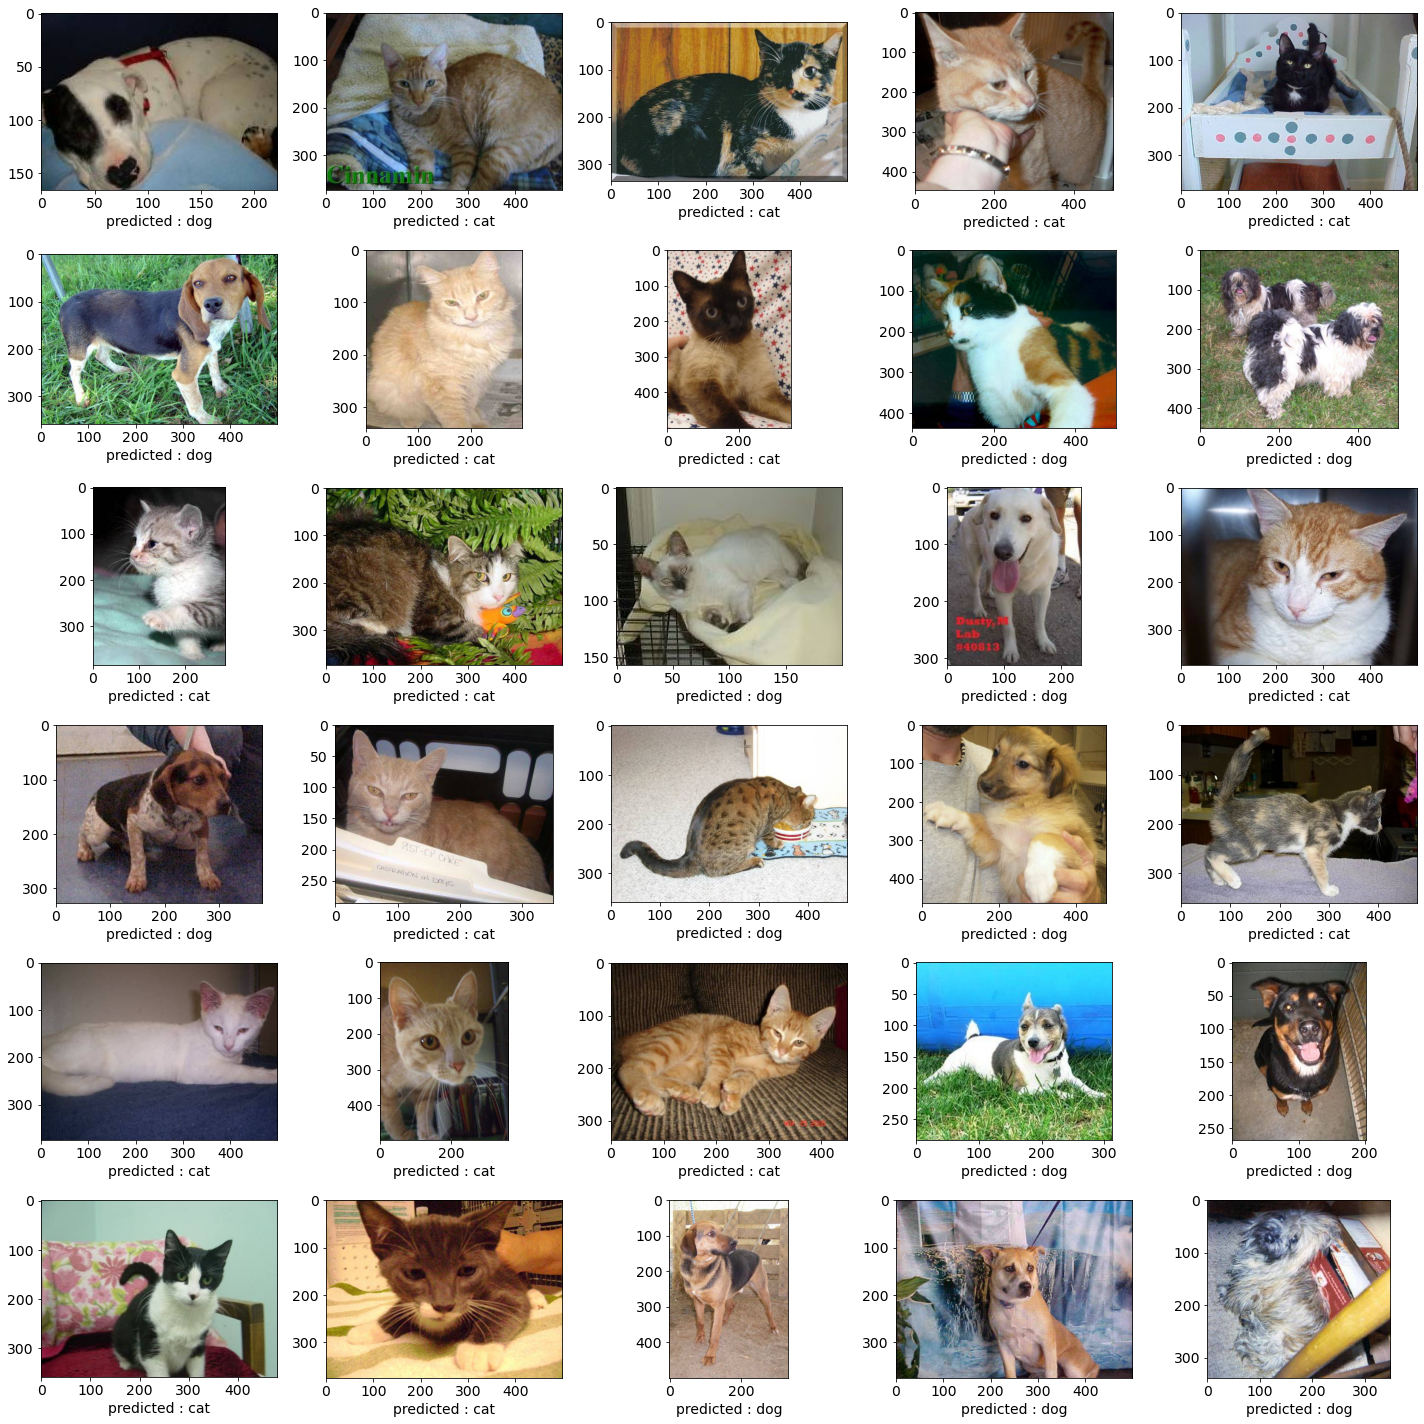

In [98]:
plt.figure(figsize=(20, 20))
plt.rc('font', size=14)
for i in range(30):
    plt.subplot(6, 5, i+1)
    y_class, conf = inference_code(i)
    image = read_image('./test1/'+test_ds.filename.values[i])
    plt.imshow(image)
    plt.xlabel('predicted : {}'.format(y_class))
    
plt.tight_layout()
plt.show()

### NEXT 30 IMAGES

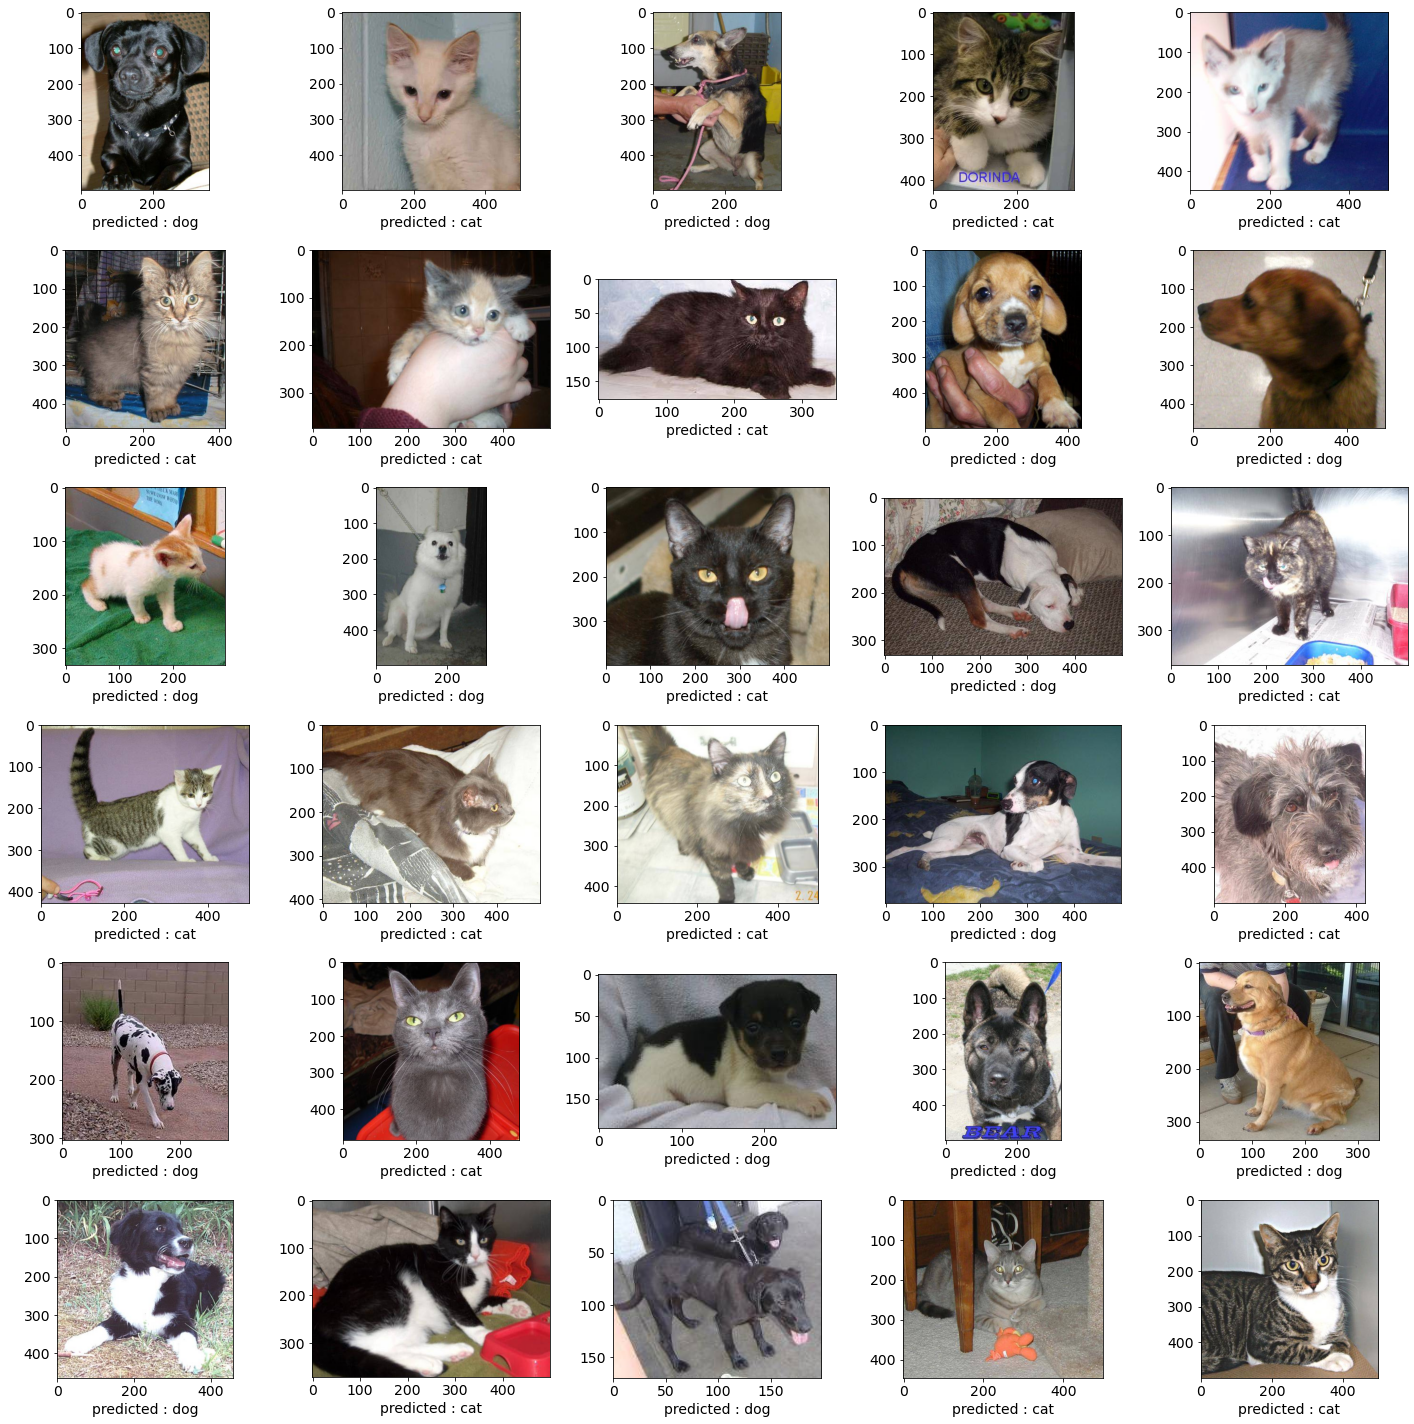

In [101]:
plt.figure(figsize=(20, 20))
plt.rc('font', size=14)
for i in range(30, 60, 1):
    j = i-30
    plt.subplot(6, 5, j+1)
    y_class, conf = inference_code(i)
    image = read_image('./test1/'+test_ds.filename.values[i])
    plt.imshow(image)
    plt.xlabel('predicted : {}'.format(y_class))
    
plt.tight_layout()
plt.show()

### NEXT 30 IMAGES

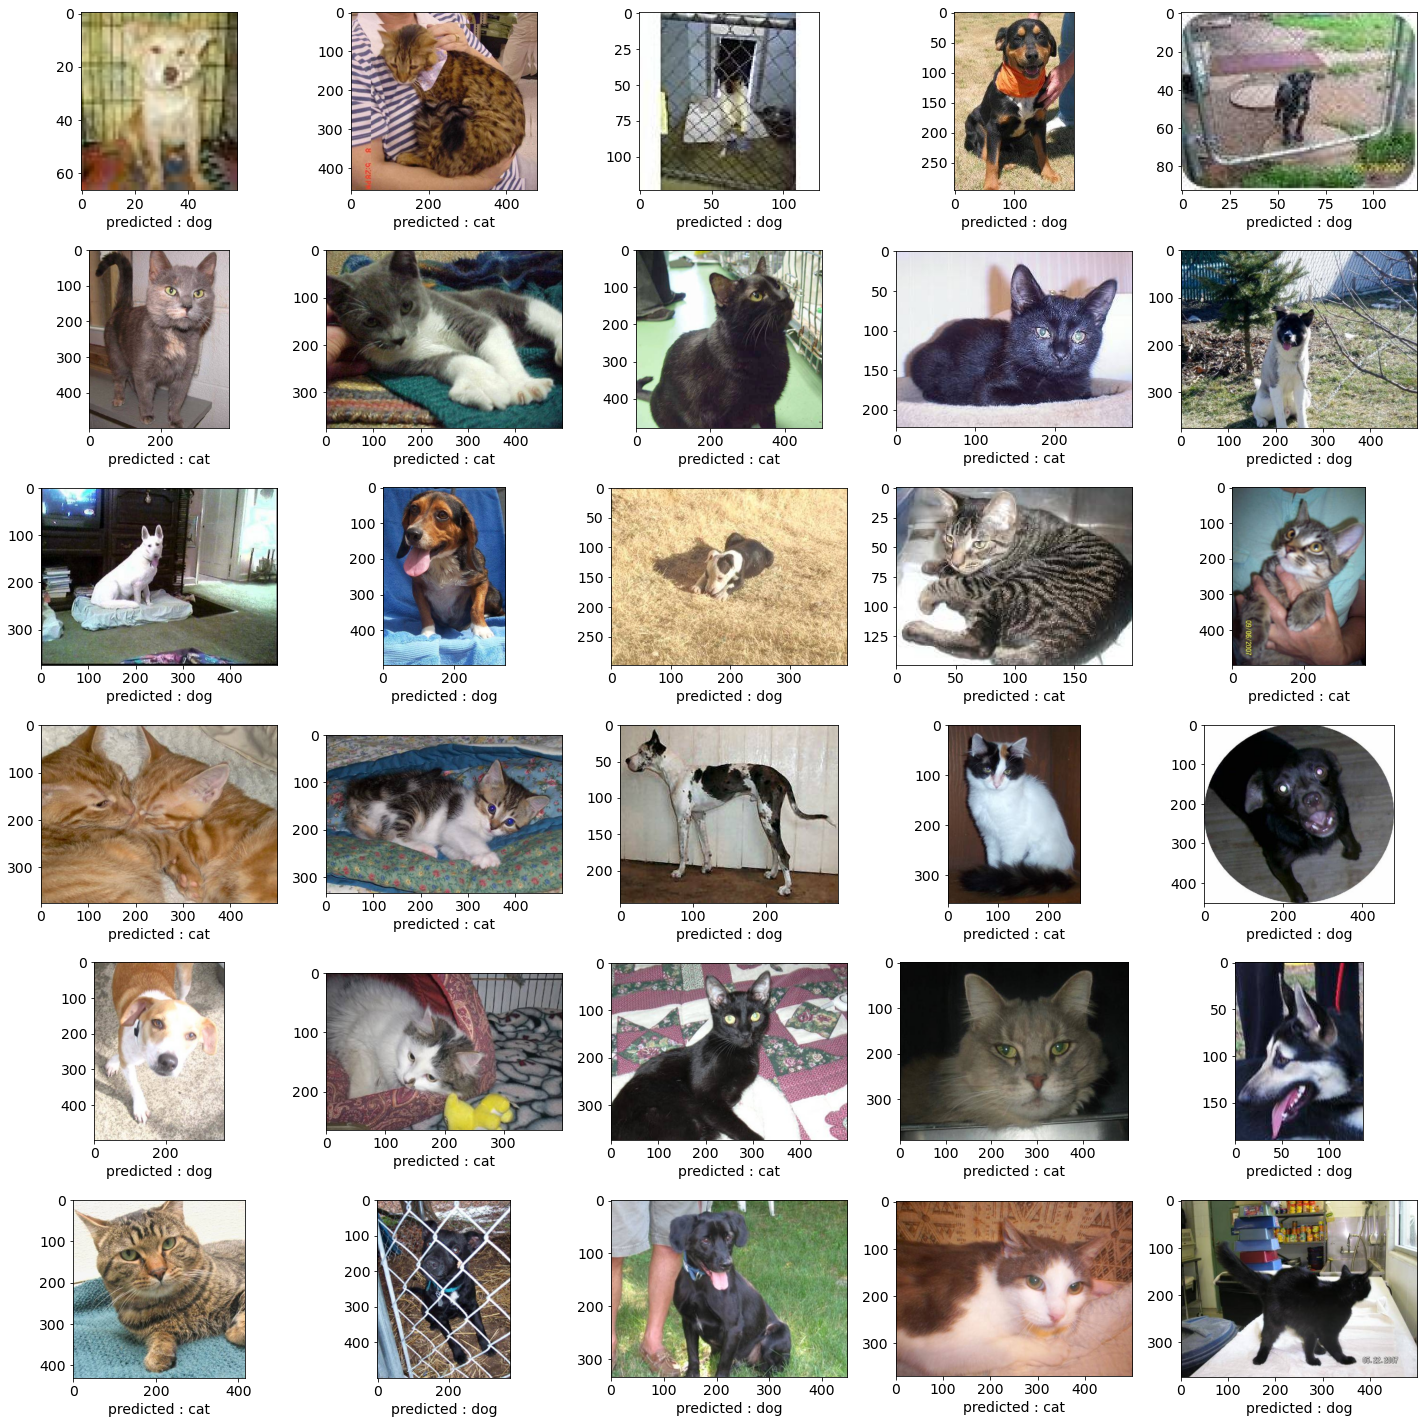

In [102]:
plt.figure(figsize=(20, 20))
plt.rc('font', size=14)
for i in range(60, 90, 1):
    j = i-60
    plt.subplot(6, 5, j+1)
    y_class, conf = inference_code(i)
    image = read_image('./test1/'+test_ds.filename.values[i])
    plt.imshow(image)
    plt.xlabel('predicted : {}'.format(y_class))
    
plt.tight_layout()
plt.show()

It gives pretty good results in just 1 epoch.